<a href="https://colab.research.google.com/github/PanLuochuan/MachineLearing/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning assignment 1**
 **Pan Luochuan(p136608)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

**I chose the Red Wine Quality data set**

The following is the data import and data preprocessing.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
red= pd.read_csv('/content/drive/MyDrive/winequality-red.csv',sep=";")

**column description:**

fixed acidity : most acids involved with wine or fixed or nonvolatile (do not evaporate readily)

volatile acidity : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste

citric acid : found in small quantities, citric acid can add 'freshness' and flavor to wines
residual sugar : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet

chlorides : the amount of salt in the wine

free sulfur dioxide : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents  microbial growth and the oxidation of wine

total sulfur dioxide : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 becomes evident in the nose and taste of wine

density : the density of water is close to that of water depending on the percent alcohol and sugar content

pH : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale

sulphates : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant

In [ ]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
red.isna().sum() #There are no missing values in the data

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [ ]:
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
value_quality=red['quality'].value_counts()
print(value_quality)
 #The quality range of red wine is 1-10, and the quality distribution range of red wine in this data set is 3-8.

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


In [ ]:
correlation=red.corr()

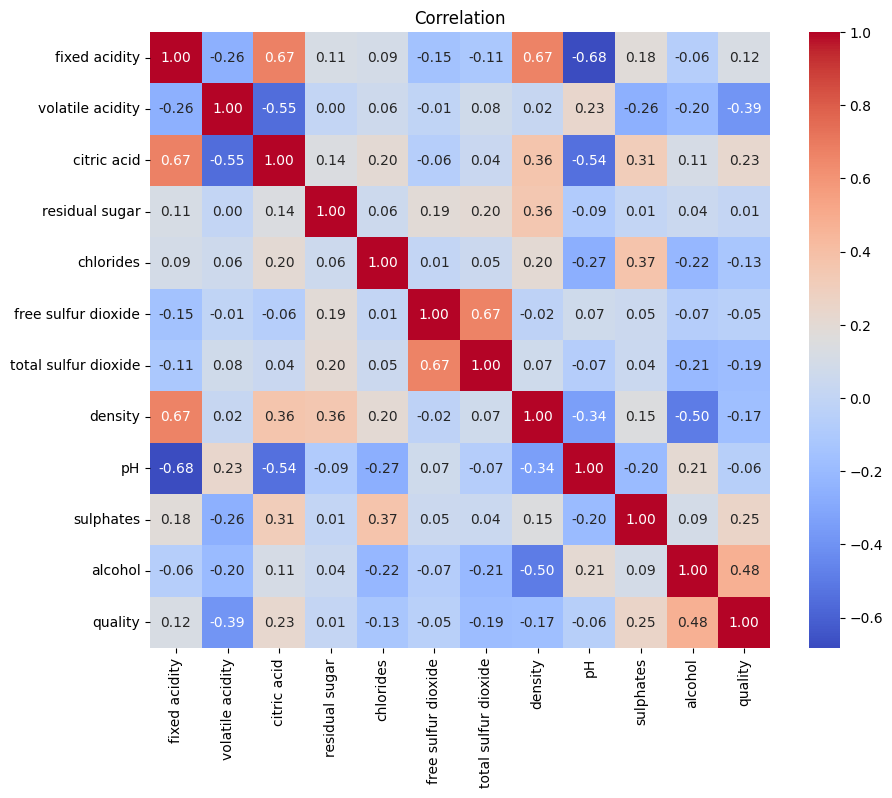

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation")
plt.show()

In [4]:
X=red.drop(columns=['quality'])

In [5]:
y=red.quality

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

**Forward Regression and K-Fold Cross-Validation(OLS)**

In [ ]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [ ]:
def forward(predictors, X_train, y_train, X_test, y_test):

    results = []
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

    models = pd.DataFrame(results)

    best_model = models.loc[models['RSS'].argmin()]
    return best_model

In [ ]:
k = 10
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1, len(X.columns)+1))
cv_errors = cv_errors.fillna(0)

In [ ]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

for j in range(1,k+1):
    predictors = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        predictors = models_cv.loc[i]["model"].model.exog_names

<ipython-input-40-22a9fdf4f8db>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-40-22a9fdf4f8db>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-40-22a9fdf4f8db>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[j][i] = models_cv.loc[i]["RSS"]
<ipython-input-40-22a9fdf4f8db>:16: SettingWithCopyWarning: 
A valu

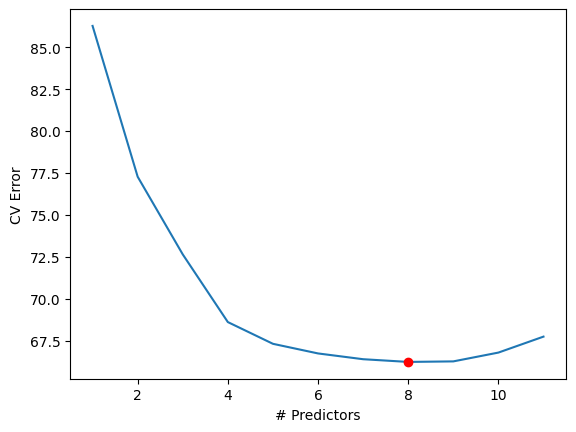

In [ ]:
cv_errors
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

#The lowest point of CV error is 8

In [ ]:
print(models_cv.loc[8 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.328e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):                        0.00
Time:                        15:12:26   Log-Likelihood:                         -1450.6
No. Observations:                1448   AIC:                                      2917.
Df Residuals:                    1440   BIC:                                      2960.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Text(0, 0.5, 'BIC')

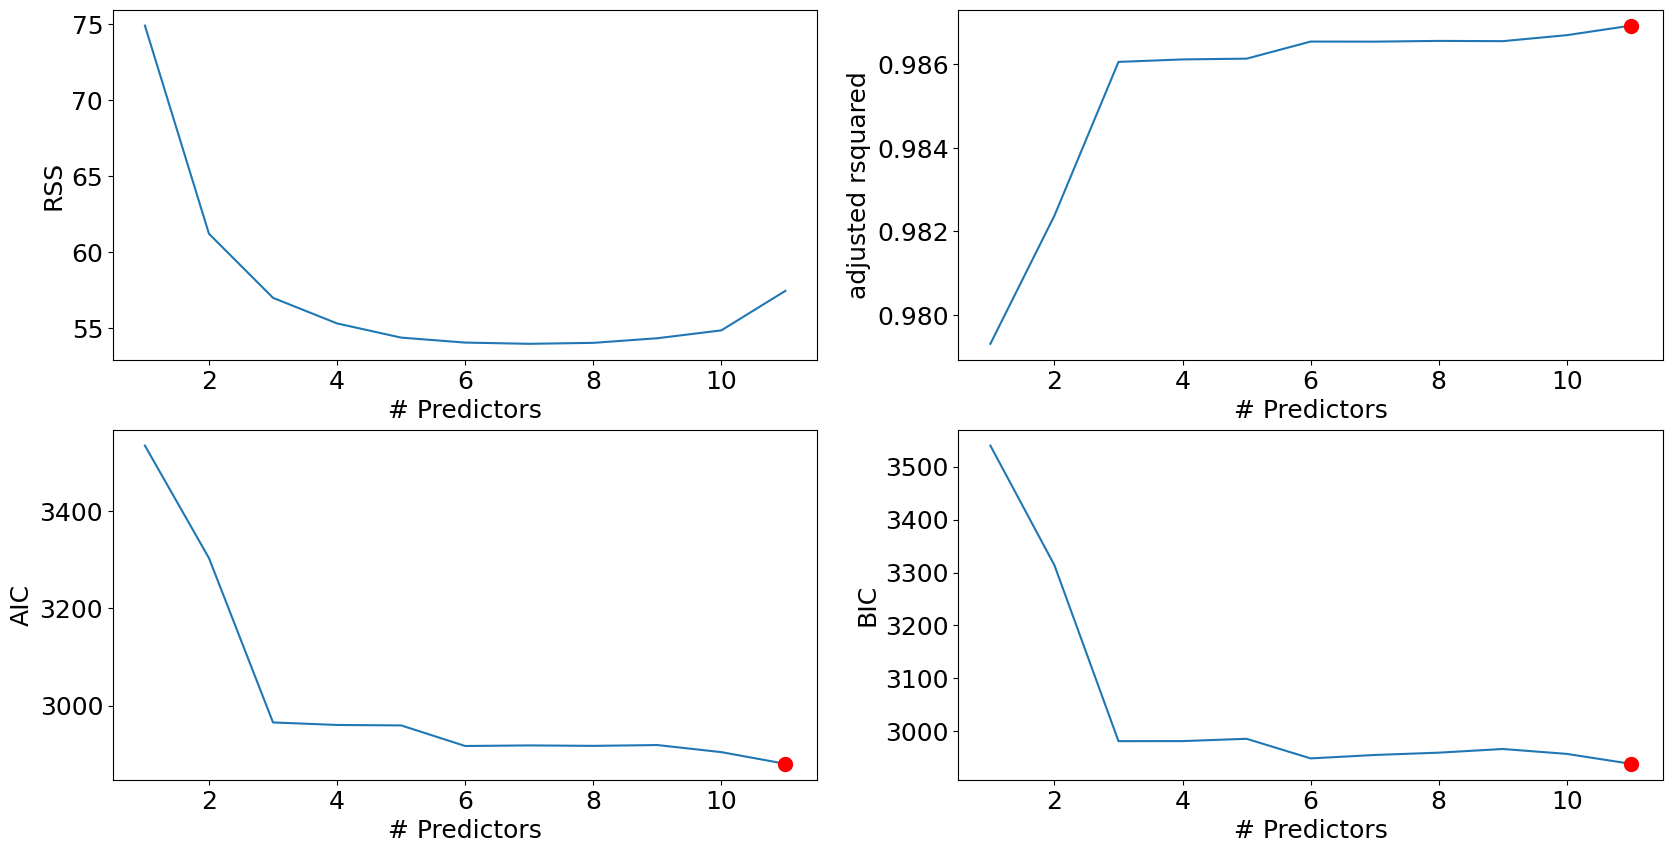

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.subplot(2, 2, 1)
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Observe its AIC, BIC, adjusted rsquared according to the chart. The value will be better after 10. We further observe the summary of 10 independent variables.

In [ ]:
print(models_cv.loc[10 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.074e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):                        0.00
Time:                        15:23:14   Log-Likelihood:                         -1442.2
No. Observations:                1448   AIC:                                      2904.
Df Residuals:                    1438   BIC:                                      2957.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

The first model contains 8 predictor variables while the second model only contains 10. Both models have the same R-squared and Adjusted R-squared, which means they have the same ability to explain the variability in the dependent variable. Ability. However, we also need to consider model complexity, as more complex models may lead to overfitting. The AIC and BIC values of the second model are lower than that of the second model. The second model is selected with 10 variables, but there is also the risk of overfitting.

**Backward Regression and K-Fold Cross-Validation(OLS)**

In [7]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [8]:
def backward(predictors, X_train, y_train, X_test, y_test):

    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
      if len(combo)==0:
        continue

      results.append(processSubset(combo, X_train, y_train, X_test, y_test))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]

    return best_model

In [9]:
k = 10
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)#

cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1, len(X.columns)+1))
cv_errors = cv_errors.fillna(0)

In [10]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

for j in range(1, k+1):
    is_train = folds != (j-1)
    is_test = folds == (j-1)

    X_train, y_train = X[is_train], y[is_train]
    X_test, y_test = X[is_test], y[is_test]

    predictors = list(X.columns)

    for i in range(1, len(X.columns) + 1):
        best_model = backward(predictors, X_train, y_train, X_test, y_test)
        predictors = best_model['model'].model.exog_names
        if len(predictors) == 1:
            break

        models_cv.loc[i] = [best_model['RSS'], best_model['model']]
        cv_errors.loc[i, j] = best_model['RSS']

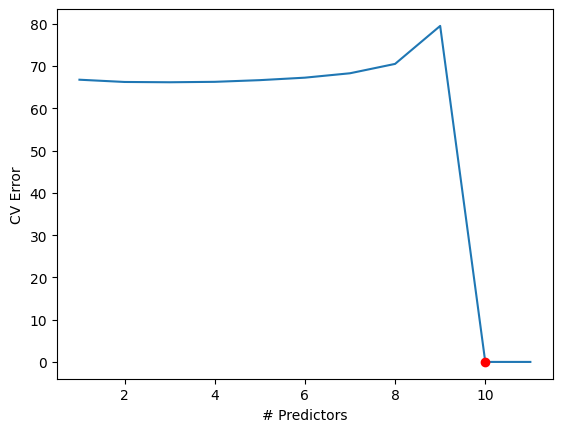

In [11]:
cv_errors
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

In [21]:
cv_error_specific = cv_errors.loc[10, ]
print(cv_error_specific)

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: 10, dtype: float64


Text(0, 0.5, 'BIC')

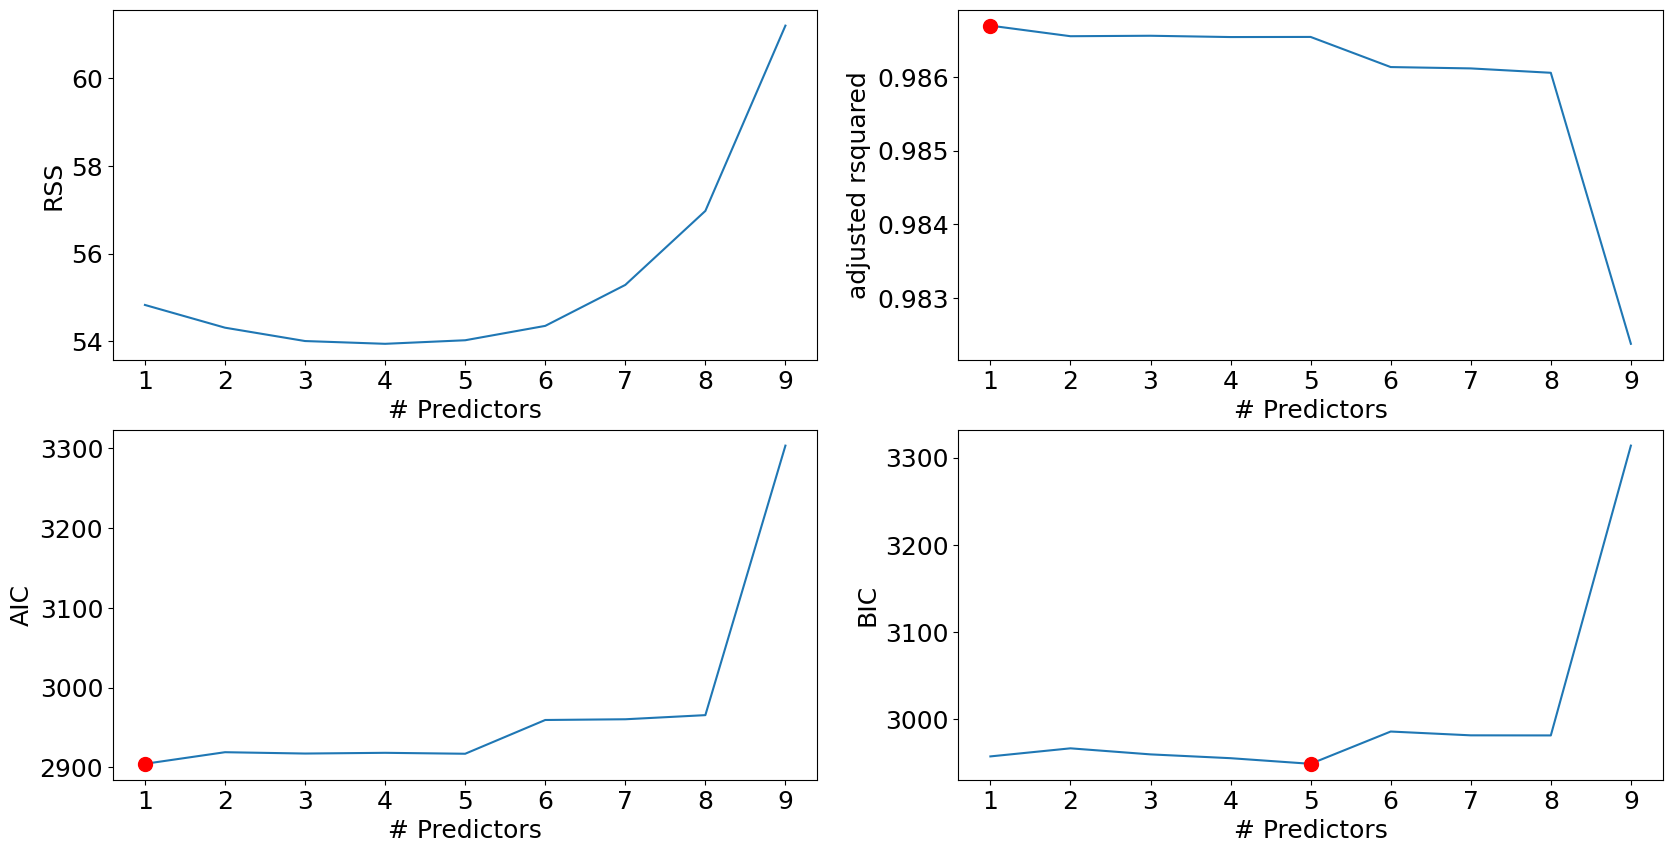

In [12]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [16]:
print(models_cv.loc[1 , "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.074e+04
Date:                Sat, 11 May 2024   Prob (F-statistic):                        0.00
Time:                        03:46:43   Log-Likelihood:                         -1442.2
No. Observations:                1448   AIC:                                      2904.
Df Residuals:                    1438   BIC:                                      2957.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

When selecting backwards to the second model based on chart selection, there are 10 independent variables.

**Forward-Backward Regression and k-Fold Cross-Validation(OLS)**

In [ ]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    model = sm.OLS(y_train, sm.add_constant(X_train[list(feature_set)]))
    regr = model.fit()
    RSS = ((regr.predict(sm.add_constant(X_test[list(feature_set)])) - y_test) ** 2).sum()
    return {"model": regr, "RSS": RSS, "AIC": regr.aic, "BIC": regr.bic, "adjusted_R_squared": regr.rsquared_adj}

In [ ]:
def forward(predictors, X_train, y_train, X_test, y_test):
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors + [p], X_train, y_train, X_test, y_test))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

In [ ]:
def backward(predictors, X_train, y_train, X_test, y_test):
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(list(combo), X_train, y_train, X_test, y_test))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

In [ ]:
def forward_backward(X, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    models_per_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Forward selection
        predictors = []
        while len(predictors) < len(X.columns):
            model = forward(predictors, X_train, y_train, X_test, y_test)
            predictors = model['model'].model.exog_names[1:]  # excluding constant
            models_per_fold.append(model)

        # Backward elimination
        while len(predictors) > 1:
            model = backward(predictors, X_train, y_train, X_test, y_test)
            predictors = model['model'].model.exog_names[1:]  # excluding constant
            models_per_fold.append(model)

    return models_per_fold

# Run the analysis
models = forward_backward(X, y)

In [ ]:
model_summaries = pd.DataFrame({
    'RSS': [model['RSS'] for model in models],
    'AIC': [model['model'].aic for model in models],
    'BIC': [model['model'].bic for model in models],
    'Adjusted R^2': [model['adjusted_R_squared'] for model in models],
    'Model': [model['model'] for model in models]
})
print(model_summaries.sort_values(by='AIC').reset_index(drop=True))

best_model_idx = model_summaries['AIC'].idxmin()
best_model = model_summaries.loc[best_model_idx]

print("\nBest Model Summary:")
print(best_model)
print("\nBest Model Detailed Summary:")
print(best_model['Model'].summary())

           RSS          AIC          BIC  Adjusted R^2  \
0    78.732165  2821.503686  2884.764130      0.367818   
1    77.676090  2822.052107  2880.040848      0.367141   
2    77.463162  2822.709616  2880.698357      0.366851   
3    75.791748  2825.517701  2862.419627      0.363860   
4    76.541781  2826.835647  2879.552685      0.364595   
..         ...          ...          ...           ...   
205  68.641377  3272.990985  3294.077800      0.146894   
206  58.520605  3286.839677  3297.383084      0.142580   
207  58.520605  3286.839677  3297.383084      0.142580   
208  71.030057  3344.567544  3360.382655      0.102765   
209  78.841837  3408.322520  3418.865927      0.061469   

                                                 Model  
0    <statsmodels.regression.linear_model.Regressio...  
1    <statsmodels.regression.linear_model.Regressio...  
2    <statsmodels.regression.linear_model.Regressio...  
3    <statsmodels.regression.linear_model.Regressio...  
4    <statsmodels.

# **Summarize**


**Forward Regression and K-Fold Cross-Validation(OLS)：**

Adjusted R-squared: 0.987, indicating that the model explains a large amount of variance.

AIC: 2904, which is relatively low, indicating that the model has better information efficiency.

BIC: 2957, a lower BIC value usually indicates a better model.

Model variables: 10, including density, volatile acidity, alcohol, fixed acidity, etc.

**Backward Regression and K-Fold Cross-Validation(OLS)：**

Adjusted R-squared: 0.987.

AIC: 2904.

BIC: 2957.

Model variables: 10.

These values are the same as the results obtained by Forward Regression and K-Fold Cross-Validation.


**Backward Regression and k-Fold Cross-Validation(OLS):**

Adjusted R-squared: 0.373, significantly lower than the previous two models.

AIC: 2822

BIC: 2885, also the lowest.

Model variables: 12

Based on the above analysis, the models obtained by Forward Regression and K-Fold Cross-Validation and Backward Regression and K-Fold Cross-Validation perform similarly and better than the model using both forward and backward selection.These two methods yielded extremely high adjusted R-squared values, and relatively low AIC and BIC values, indicating that the model has excellent explanatory power and moderate complexity.

The fact that both methods result in the same model may be because the characteristics of the data set make key features highly salient in any choice of steps, whether incremental addition or incremental removal.

**The formula of the optimal model is :**

quality=3.7771✖density-1.2266✖volatile acifity+0.3253✖alcohol+0.0135✖fixed acidity-0.2986✖citric acid+0.7020✖sulphates+0.0048✖free sulfur dioxide-0.3915✖PH-0.0021✖residual sugar-0.0031✖total sulfur dioxide